In [1]:
import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import types
import random

In [2]:
config = types.SimpleNamespace()
config.batch_size = 32
config.discriminator_extra_steps =3 
config.gp_weight = 10
config.latent_dim = 16
config.learning_rate=0.01
config.feature_dim = 32
config.label_dim = 1
config.random_seed = 1
config.sample_num = config.batch_size*10

tf.random.set_seed(config.random_seed)
np.random.seed(config.random_seed)
random.seed(config.random_seed)

In [3]:

# x = np.random.rand(config.batch_size, 32)   #change mean from 0 to 2
mean = 0.0
stddev = 1.0
class_num = int(config.sample_num/2)
size = (class_num, 32)   # Example shape

x_1 = np.random.normal(loc=0, scale=stddev, size=size)
x_2 = np.random.normal(loc=5, scale=stddev, size=size)
x = np.concatenate([x_1,x_2],axis=0)
y = np.array([0]*class_num + [1]*class_num)


In [4]:
x.shape, y.shape

((320, 32), (320,))

In [5]:
x_tr = tf.cast(tf.convert_to_tensor(x), tf.float32)
y_tr = tf.cast(tf.convert_to_tensor(y), tf.float32)

In [6]:
def show_features_distribution(feature, labels):
    ##show features distribution generate from each client
    tsne = TSNE(n_components=2, verbose=1, random_state=1)
    z = tsne.fit_transform(feature)

    df = pd.DataFrame()
    df["comp-1"] = z[:,0]
    df["comp-2"] = z[:,1]

    df['classes'] = labels 
    ax = sns.scatterplot(x="comp-1", y="comp-2", hue=df.classes.tolist(),
                data=df) 
        
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))





In [7]:
generator = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(config.latent_dim+1,)),
        tf.keras.layers.Dense(32, activation=tf.nn.relu),
        tf.keras.layers.Dense(64, activation=tf.nn.relu),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(config.feature_dim),
    ],
    name="generator",
)

In [8]:
discriminator = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(config.feature_dim)),
        tf.keras.layers.Flatten(), 
        tf.keras.layers.Dense(512, activation=tf.nn.leaky_relu ),
        tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu ),
        tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu ),
        tf.keras.layers.Dense(1+config.label_dim),
    ],
    name="discriminator",
)

In [9]:
config

namespace(batch_size=32,
          discriminator_extra_steps=3,
          gp_weight=10,
          latent_dim=16,
          learning_rate=0.01,
          feature_dim=32,
          label_dim=1,
          random_seed=1,
          sample_num=320)

In [10]:
    
class GAN(tf.keras.Model):
    def __init__(self, config, discriminator, generator, model):
        super().__init__()
        self.config = config
        self.discriminator = discriminator
        self.generator = generator
        self.cls = model
        self.latent_dim = config.latent_dim   #generator input dim
        self.d_loss_tracker = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_tracker = tf.keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn_binary, loss_fn_categorical, binary_accuracy, categorical_accuracy, run_eagerly):
        super().compile(run_eagerly = run_eagerly)
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn_binary = loss_fn_binary
        self.loss_fn_categorical = loss_fn_categorical
        self.binary_accuracy = binary_accuracy
        self.categorical_accuracy = categorical_accuracy
    
    def set_train_y(self, train_y):
        self.train_y = train_y

    def generate_fake_features(self):
        noise = tf.random.normal([len(self.train_y), self.latent_dim])
        y = tf.expand_dims(self.train_y, axis=1)
        seed = tf.concat(
            [noise, y], axis=1
            )
        fake_features = self.generator(seed)
        return fake_features
    
    #features_version
    def gradient_penalty(self, real_features, generated_features):
        """ features_version
        Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([self.config.batch_size, 1], 0.0, 1.0)
        diff = generated_features - real_features
        interpolated = real_features + alpha * diff
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)
            pred, _ = pred[:, :1], pred[:, 1:]

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    @tf.function
    # Modify Train step for GAN
    def train_step(self,data):
        x, y = data
        y = tf.expand_dims(y, axis=1)
        real_features = x
        # Train the discriminator first.
        for i in range(self.config.discriminator_extra_steps):
            noise = tf.random.normal([y.shape[0], self.latent_dim])

            random_vector_labels = tf.concat([noise, y], axis=1)

            with tf.GradientTape() as disc_tape:
                generated_features = self.generator(random_vector_labels, training=True)

                # Combine them with real images. Note that we are concatenating the labels
                # with these images here.
                combined_features = tf.concat(
                    [real_features, generated_features], axis=0
                )

                # Assemble labels discriminating real from fake images.
                binary_labels = tf.concat(  
                    [tf.ones((self.config.batch_size, 1)), tf.zeros((self.config.batch_size, 1))], axis=0
                )

                # Add random noise to the labels - important trick!
                # labels += 0.05 * tf.random.uniform(tf.shape(labels))
                
                category_label = tf.concat(  
                    [y, y], axis=0
                )
            
                predictions = self.discriminator(combined_features, training=True)
                binary_predictions, category_predictions = predictions[:, :1], predictions[:, 1:]

                disc_binary_cost = self.loss_fn_binary(binary_labels,binary_predictions)
                disc_categorical_cost = self.loss_fn_categorical(category_label, category_predictions)
    
                # Calculate the gradient penalty
                gp = self.gradient_penalty(real_features, generated_features)    
                # Add the gradient penalty to the original discriminator loss
                disc_loss = disc_binary_cost +  disc_categorical_cost  +  gp * self.config.gp_weight

            # Calculate Gradient
            grad_disc = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(grad_disc, self.discriminator.trainable_variables))

        # Train the generator
        # Get the latent vector
        noise = tf.random.normal([y.shape[0], self.latent_dim])
        random_vector_labels = tf.concat(
            [noise, y], axis=1
            )
        # Assemble labels that say "all real images". 
        misleading_labels = tf.ones((self.config.batch_size, 1))
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_features = self.generator(random_vector_labels, training=True)
            
            fake_predictions = self.discriminator(generated_features, training=True)
            binary_fake_predictions, category_fake_predictions = fake_predictions[:, :1], fake_predictions[:, 1:]

            gen_binary_loss = self.loss_fn_binary(misleading_labels, binary_fake_predictions) #lead classify to 
            gen_categorical_loss  = self.loss_fn_categorical(y, category_fake_predictions) 
            gen_loss = gen_binary_loss + gen_categorical_loss

        grad_gen = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(grad_gen, self.generator.trainable_variables))

        # Update metrics and return their value.
        self.d_loss_tracker.update_state(disc_loss)
        self.g_loss_tracker.update_state(gen_loss)
        self.binary_accuracy.update_state(binary_labels, binary_predictions)
        self.categorical_accuracy.update_state(category_label, category_predictions)
        return {
            "d_loss": self.d_loss_tracker.result(),
            "g_loss": self.g_loss_tracker.result(),
            "binary_accuracy": self.binary_accuracy.result(),
            "categorical_accuracy": self.categorical_accuracy.result(),
        }
    
    @tf.function
    def test_step(self,data):
        x, y = data
        real_features = x
        noise = tf.random.normal([y.shape[0], self.latent_dim])
        y = tf.expand_dims(y, axis=1)
        random_vector_labels = tf.concat(
            [noise, y], axis=1
            )

        generated_features = self.generator(random_vector_labels, training=False)
        combined_features = tf.concat(
            [real_features, generated_features], axis=0
        )
        # Assemble labels discriminating real from fake images.
        binary_labels = tf.concat(  #set real img classify to zero
            [tf.ones((self.config.batch_size, 1)), tf.zeros((self.config.batch_size, 1))], axis=0
        )
        misleading_labels = tf.ones((self.config.batch_size, 1))

        category_label = tf.concat(  
                    [y, y], axis=0
                )
        predictions = self.discriminator(combined_features, training=False)
        binary_predictions, category_predictions = predictions[:, :1], predictions[:, 1:]
        
        #using fake img's output to count generator loss
        gen_binary_loss = self.loss_fn_binary(misleading_labels,binary_predictions[self.config.batch_size:])
        gen_categorical_loss  = self.loss_fn_categorical(y, category_predictions[self.config.batch_size:]) 
        gen_loss = gen_binary_loss + gen_categorical_loss
        
        disc_binary_cost = self.loss_fn_binary(binary_labels, binary_predictions)
        disc_categorical_cost = self.loss_fn_categorical(category_label, category_predictions)
        # Calculate the gradient penalty
        gp = self.gradient_penalty(real_features, generated_features)     
        # Add the gradient penalty to the original discriminator loss
        disc_loss = disc_binary_cost + disc_categorical_cost + gp * self.config.gp_weight  
        
        # Update metrics and return their value.
        self.d_loss_tracker.update_state(disc_loss)
        self.g_loss_tracker.update_state(gen_loss)
        self.binary_accuracy.update_state(binary_labels, binary_predictions)
        self.categorical_accuracy.update_state(category_label, category_predictions)
        return {
            "d_loss": self.d_loss_tracker.result(),
            "g_loss": self.g_loss_tracker.result(),
            "binary_accuracy": self.binary_accuracy.result(),
            "categorical_accuracy": self.categorical_accuracy.result(),
        }

In [11]:
gan = GAN(config=config, discriminator=discriminator, generator=generator, model = None)
gan.set_train_y(y_tr)
gan.compile(
    d_optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=config.learning_rate),
    g_optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=config.learning_rate),
    loss_fn_binary= tf.keras.losses.BinaryCrossentropy(from_logits=True),
    loss_fn_categorical = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    binary_accuracy = tf.keras.metrics.BinaryAccuracy(name='disc_binary_accuracy'), 
    categorical_accuracy = tf.keras.metrics.CategoricalAccuracy(name='disc_categorical_accuracy'),
    run_eagerly = True
)

In [12]:
gan.fit(x=x_tr, y=y_tr, batch_size=32,epochs=100, verbose=1, shuffle=True)

Epoch 1/100
10/10 [==============================] - 1s 5ms/step - d_loss: 1.7071 - g_loss: 2.0172 - binary_accuracy: 0.8936 - categorical_accuracy: 1.0000
Epoch 2/100
10/10 [==============================] - 0s 5ms/step - d_loss: 0.8133 - g_loss: 2.1381 - binary_accuracy: 0.8964 - categorical_accuracy: 1.0000
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - d_loss: 0.6216 - g_loss: 2.7624 - binary_accuracy: 0.9864 - categorical_accuracy: 1.0000
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - d_loss: 0.5017 - g_loss: 3.7623 - binary_accuracy: 0.9876 - categorical_accuracy: 1.0000
Epoch 5/100
10/10 [==============================] - 0s 5ms/step - d_loss: 0.5320 - g_loss: 3.1908 - binary_accuracy: 0.9934 - categorical_accuracy: 1.0000
Epoch 6/100
10/10 [==============================] - 0s 5ms/step - d_loss: 0.4150 - g_loss: 2.5873 - binary_accuracy: 0.9857 - categorical_accuracy: 1.0000
Epoch 7/100
10/10 [==============================] - 0s 5ms/step

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 320 samples in 0.000s...
[t-SNE] Computed neighbors for 320 samples in 0.037s...
[t-SNE] Computed conditional probabilities for sample 320 / 320
[t-SNE] Mean sigma: 2.319873
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.695404
[t-SNE] KL divergence after 1000 iterations: 1.116428


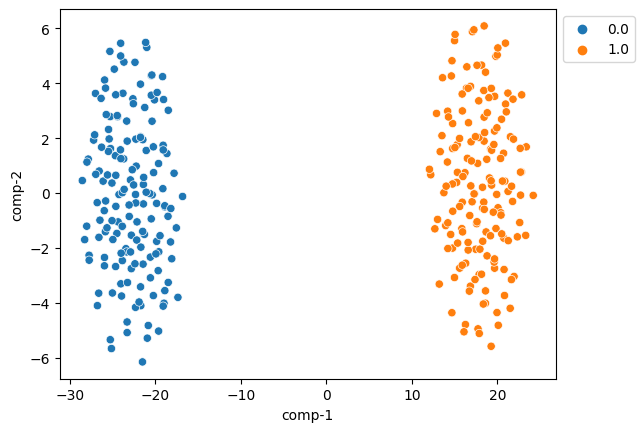

In [13]:
show_features_distribution(x_tr, y_tr)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 320 samples in 0.000s...
[t-SNE] Computed neighbors for 320 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 320 / 320
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 42.239891
[t-SNE] KL divergence after 1000 iterations: -0.009215


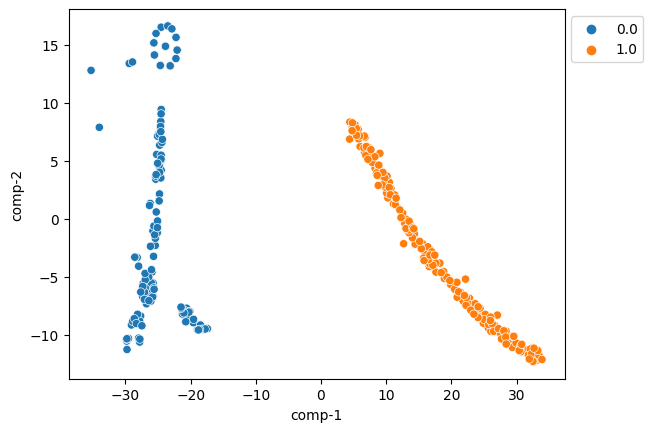

In [14]:
fake_feature = gan.generate_fake_features()
show_features_distribution(fake_feature, y_tr)

In [15]:
print(fake_feature.shape)
mean_1 = np.mean(fake_feature[:class_num])
mean_2 = np.mean(fake_feature[class_num:])
std_1 = np.std(fake_feature[:class_num])
std_2 = np.std(fake_feature[class_num:])
print("mean_1:",mean_1)
print("mean_2:",mean_2)
print("std_1:",std_1)
print("std_2:",std_2)

(320, 32)
mean_1: 0.003296125
mean_2: 5.628801
std_1: 0.38757744
std_2: 1.1461909


In [16]:
mean_1 = np.mean(x[:class_num])
mean_2 = np.mean(x[class_num:])
std_1 = np.std(x[:class_num])
std_2 = np.std(x[class_num:])
print("mean_1:",mean_1)
print("mean_2:",mean_2)
print("std_1:",std_1)
print("std_2:",std_2)

mean_1: 0.024384636629303846
mean_2: 4.997881093188071
std_1: 1.001064819025745
std_2: 0.9934312347177667


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 640 samples in 0.000s...
[t-SNE] Computed neighbors for 640 samples in 0.053s...
[t-SNE] Computed conditional probabilities for sample 640 / 640
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.190979
[t-SNE] KL divergence after 1000 iterations: 0.648048


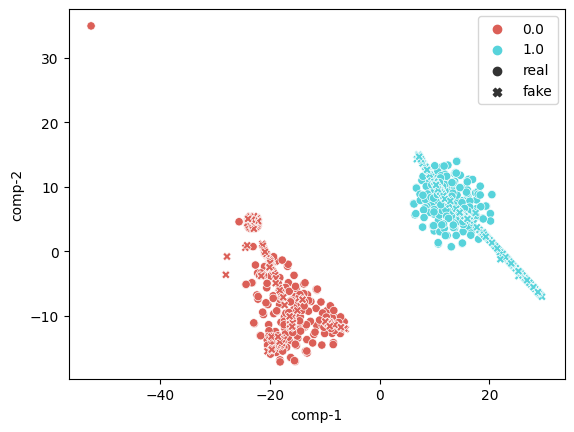

In [17]:
def generate_tsne_images(config, real_features,real_labels,  fake_features, fake_lables):
    real_labels = tf.expand_dims(real_labels, axis=-1)
    fake_lables = tf.expand_dims(fake_lables, axis=-1)
    ## for features
    compare_input = tf.concat([real_features,fake_features],0)
    real_features_num = real_features.shape[0]
    fake_features_num = fake_features.shape[0]
    data = tf.reshape(compare_input,[real_features_num+fake_features_num,-1])

    tsne = TSNE(n_components=2, verbose=1, random_state=config.random_seed)
    z = tsne.fit_transform(data)

    df = pd.DataFrame()
    df["comp-1"] = z[:,0]
    df["comp-2"] = z[:,1]
    #show discriminator output
    df.loc[:real_features_num-1,'y'] = "real"
    df.loc[real_features_num:,'y'] = "fake"
    real_labels = np.array(real_labels)
    fake_lables = np.array(fake_lables)
    df.loc[:real_features_num-1,"classes"] = real_labels 
    df.loc[real_features_num:,"classes"] = fake_lables
    sns.scatterplot(x="comp-1", y="comp-2", hue=df.classes.tolist(), style=df.y.tolist(),
                    palette=sns.color_palette("hls", 2),
                    data=df)

generate_tsne_images(config, x_tr, y_tr, fake_feature, y_tr)